# JIGSAW SSL

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
from torch import cat
from PIL import Image
np.random.seed(0)
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.datasets import CIFAR10
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 20.9 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38243 sha256=831f236f04b441d3a05e6a57f3a6c354ed5a6049ece7893d44cfa28189ca955d
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Model Architecture
https://arxiv.org/pdf/1603.09246.pdf, Model Reference

https://github.com/jiecaoyu/pytorch_imagenet/blob/master/networks/model_list/alexnet.py, LRN

In [40]:
class LRN(nn.Module):
    def __init__(self, local_size=1, alpha=1.0, beta=0.75, ACROSS_CHANNELS=True):
        super(LRN, self).__init__()
        self.ACROSS_CHANNELS = ACROSS_CHANNELS
        if ACROSS_CHANNELS:
            self.average=nn.AvgPool3d(kernel_size=(local_size, 1, 1),
                    stride=1,padding=(int((local_size-1.0)/2), 0, 0))
        else:
            self.average=nn.AvgPool2d(kernel_size=local_size,
                    stride=1,padding=int((local_size-1.0)/2))
        self.alpha = alpha
        self.beta = beta


    def forward(self, x):
        if self.ACROSS_CHANNELS:
            div = x.pow(2).unsqueeze(1)
            div = self.average(div).squeeze(1)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        else:
            div = x.pow(2)
            div = self.average(div)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        x = x.div(div)
        return x

In [41]:
import sys
sys.path.append('Utils')

class Model(nn.Module):

    def __init__(self, classes=100):
        super(Model, self).__init__()

        self.conv = nn.Sequential()
        self.conv.add_module('conv1_s1',nn.Conv2d(3, 96, kernel_size=11, stride=2, padding=0))
        self.conv.add_module('relu1_s1',nn.ReLU(inplace=True))
        self.conv.add_module('pool1_s1',nn.MaxPool2d(kernel_size=3, stride=2))
        self.conv.add_module('lrn1_s1',LRN(local_size=5, alpha=0.0001, beta=0.75))

        self.conv.add_module('conv2_s1',nn.Conv2d(96, 256, kernel_size=5, padding=2, groups=2))
        self.conv.add_module('relu2_s1',nn.ReLU(inplace=True))
        self.conv.add_module('pool2_s1',nn.MaxPool2d(kernel_size=3, stride=2))
        self.conv.add_module('lrn2_s1',LRN(local_size=5, alpha=0.0001, beta=0.75))

        self.conv.add_module('conv3_s1',nn.Conv2d(256, 384, kernel_size=3, padding=1))
        self.conv.add_module('relu3_s1',nn.ReLU(inplace=True))

        self.conv.add_module('conv4_s1',nn.Conv2d(384, 384, kernel_size=3, padding=1, groups=2))
        self.conv.add_module('relu4_s1',nn.ReLU(inplace=True))

        self.conv.add_module('conv5_s1',nn.Conv2d(384, 256, kernel_size=3, padding=1, groups=2))
        self.conv.add_module('relu5_s1',nn.ReLU(inplace=True))
        self.conv.add_module('pool5_s1',nn.MaxPool2d(kernel_size=3, stride=2))

        self.fc6 = nn.Sequential()
        self.fc6.add_module('fc6_s1',nn.Linear(256*3*3, 1024))
        self.fc6.add_module('relu6_s1',nn.ReLU(inplace=True))
        self.fc6.add_module('drop6_s1',nn.Dropout(p=0.5))

        self.fc7 = nn.Sequential()
        self.fc7.add_module('fc7',nn.Linear(9*1024,4096))
        self.fc7.add_module('relu7',nn.ReLU(inplace=True))
        self.fc7.add_module('drop7',nn.Dropout(p=0.5))

        self.classifier = nn.Sequential()
        self.classifier.add_module('fc8',nn.Linear(4096, classes))

    def load(self,checkpoint):
        model_dict = self.state_dict()
        pretrained_dict = torch.load(checkpoint)
        pretrained_dict = {k: v for k, v in list(pretrained_dict.items()) if k in model_dict and 'fc8' not in k}
        model_dict.update(pretrained_dict)
        self.load_state_dict(model_dict)
        print([k for k, v in list(pretrained_dict.items())])

    def save(self,checkpoint):
        torch.save(self.state_dict(), checkpoint)

    def forward(self, x):
        B,T,C,H,W = x.size()
        x = x.transpose(0,1)

        x_list = []

        for i in range(9):
            z = self.conv(x[i])
            z = self.fc6(z.view(B,-1))
            z = z.view([B,1,-1])
            x_list.append(z)

        x = cat(x_list,1)
        x = self.fc7(x.view(B,-1))
        x = self.classifier(x)
        return x

def weights_init(model):
    if type(model) in [nn.Conv2d,nn.Linear]:
        nn.init.xavier_normal(model.weight.data)
        nn.init.constant(model.bias.data, 0.1)


## Dataset

In [42]:
class UpsampleCIFAR10(Dataset):
    def __init__(self, cifar_dataset, target_size=(255, 255)):
        self.cifar_dataset = cifar_dataset
        self.target_size = target_size
        self.upsample_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(self.target_size),
        ])

    def __len__(self):
        return len(self.cifar_dataset)

    def __getitem__(self, index):
        image, label = self.cifar_dataset[index]
        upsampled_image = self.upsample_transform(image)
        return upsampled_image, label

In [43]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainset = UpsampleCIFAR10(train)
testset = UpsampleCIFAR10(test)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [44]:
from tqdm import trange
import numpy as np
import itertools
from scipy.spatial.distance import cdist

def get_permutations(classes = 1000):
  P_hat = np.array(list(itertools.permutations(list(range(9)), 9)))
  n = P_hat.shape[0]
  for i in trange(classes):
      if i==0:
          j = np.random.randint(n)
          P = np.array(P_hat[j]).reshape([1,-1])
      else:
          P = np.concatenate([P,P_hat[j].reshape([1,-1])],axis=0)

      P_hat = np.delete(P_hat,j,axis=0)
      D = cdist(P,P_hat, metric='hamming').mean(axis=0).flatten()
      j = D.argmax()
  return P

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [45]:
class DataLoader(data.Dataset):
    def __init__(self, dataset, classes=100):
        self.dataset = dataset
        self.permutations = self.__retrive_permutations(classes)
        self.__image_transformer = transforms.Compose([
            transforms.Resize(256, Image.BILINEAR),
            transforms.CenterCrop(255)])
        self.__augment_tile = transforms.Compose([
            transforms.RandomCrop(64),
            transforms.Resize((75, 75), Image.BILINEAR),
            transforms.ToTensor(),
        ])

    def __getitem__(self, index):
        img = self.dataset[index][0].convert('RGB')
        if np.random.rand() < 0.30:
            img = img.convert('LA').convert('RGB')
        if img.size[0] != 32:
            img = self.__image_transformer(img)
        s = float(img.size[0]) / 3
        a = s / 2
        tiles = [None] * 9
        for n in range(9):
            i = n / 3
            j = n % 3
            c = [a * i * 2 + a, a * j * 2 + a]
            c = np.array([c[1] - a, c[0] - a, c[1] + a + 1, c[0] + a + 1]).astype(int)
            tile = img.crop(c.tolist())
            tile = self.__augment_tile(tile)
            m, s = tile.view(3, -1).mean(dim=1).numpy(), tile.view(3, -1).std(dim=1).numpy()
            s[s == 0] = 1
            norm = transforms.Normalize(mean=m.tolist(), std=s.tolist())
            tile = norm(tile)
            tiles[n] = tile

        order = np.random.randint(len(self.permutations))
        data = [tiles[self.permutations[order][t]] for t in range(9)]
        data = torch.stack(data, 0)
        return data, int(order), tiles

    def __len__(self):
        return len(self.dataset)

    def __retrive_permutations(self, classes):
        return get_permutations(classes)

In [46]:
batch_size = 64
train_data = DataLoader(trainset)
test_data = DataLoader(testset)
train_loader = torch.utils.data.DataLoader(dataset= train_data,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=2)

100%|██████████| 100/100 [00:23<00:00,  4.24it/s]


In [47]:
for i, (image, label, original) in enumerate(train_loader):
  print(i, image.shape, label.shape)
  break

0 torch.Size([64, 9, 3, 75, 75]) torch.Size([64])


In [17]:
N = len(train_data.dataset)
iter_per_epoch = N / batch_size

In [18]:
model = Model(100)
model.cuda()

Model(
  (conv): Sequential(
    (conv1_s1): Conv2d(3, 96, kernel_size=(11, 11), stride=(2, 2))
    (relu1_s1): ReLU(inplace=True)
    (pool1_s1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (lrn1_s1): LRN(
      (average): AvgPool3d(kernel_size=(5, 1, 1), stride=1, padding=(2, 0, 0))
    )
    (conv2_s1): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
    (relu2_s1): ReLU(inplace=True)
    (pool2_s1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (lrn2_s1): LRN(
      (average): AvgPool3d(kernel_size=(5, 1, 1), stride=1, padding=(2, 0, 0))
    )
    (conv3_s1): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3_s1): ReLU(inplace=True)
    (conv4_s1): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
    (relu4_s1): ReLU(inplace=True)
    (conv5_s1): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
    (re

In [19]:
def compute_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

## Training

In [20]:
import time
num_epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,momentum=0.9, weight_decay=5e-4)
for epoch in range(num_epochs):
  t= time.time()
  for i, (images, labels, original) in enumerate(train_loader):
    images = Variable(images)
    labels = Variable(labels)
    images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()
    outputs = model(images)
    prec1 = compute_accuracy(outputs.cpu().data, labels.cpu().data, topk=(1,))
    acc = prec1[0]
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    loss = float(loss.cpu().data.numpy())
  print(f"Epoch {epoch}---Step{i+1} --- Accuracy {acc} --- Time:{time.time()-t}")

Epoch 0---Step782 --- Accuracy 0.0 --- Time:512.2298622131348
Epoch 1---Step782 --- Accuracy 0.0 --- Time:506.73582434654236
Epoch 2---Step782 --- Accuracy 0.0 --- Time:497.7326593399048
Epoch 3---Step782 --- Accuracy 43.75 --- Time:508.00422072410583
Epoch 4---Step782 --- Accuracy 75.0 --- Time:503.73362922668457
Epoch 5---Step782 --- Accuracy 50.0 --- Time:492.6442952156067
Epoch 6---Step782 --- Accuracy 75.0 --- Time:531.9372880458832
Epoch 7---Step782 --- Accuracy 81.25 --- Time:527.133204460144
Epoch 8---Step782 --- Accuracy 68.75 --- Time:529.0457561016083
Epoch 9---Step782 --- Accuracy 56.25 --- Time:529.8386704921722
Epoch 10---Step782 --- Accuracy 50.0 --- Time:524.7993161678314
Epoch 11---Step782 --- Accuracy 93.75 --- Time:522.6460123062134
Epoch 12---Step782 --- Accuracy 87.5 --- Time:521.074241399765
Epoch 13---Step782 --- Accuracy 75.0 --- Time:511.4657597541809
Epoch 14---Step782 --- Accuracy 68.75 --- Time:526.6302170753479
Epoch 15---Step782 --- Accuracy 62.5 --- Time:

In [23]:
torch.save(model, "CFN.pt")

In [53]:
!ls data/

cifar-10-batches-py  cifar-10-python.tar.gz


In [54]:
uploaded_model = torch.load("/kaggle/input/weights/CFN.pt")
uploaded_model.eval()

Model(
  (conv): Sequential(
    (conv1_s1): Conv2d(3, 96, kernel_size=(11, 11), stride=(2, 2))
    (relu1_s1): ReLU(inplace=True)
    (pool1_s1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (lrn1_s1): LRN(
      (average): AvgPool3d(kernel_size=(5, 1, 1), stride=1, padding=(2, 0, 0))
    )
    (conv2_s1): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
    (relu2_s1): ReLU(inplace=True)
    (pool2_s1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (lrn2_s1): LRN(
      (average): AvgPool3d(kernel_size=(5, 1, 1), stride=1, padding=(2, 0, 0))
    )
    (conv3_s1): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3_s1): ReLU(inplace=True)
    (conv4_s1): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
    (relu4_s1): ReLU(inplace=True)
    (conv5_s1): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
    (re

## Gradcam Analysis

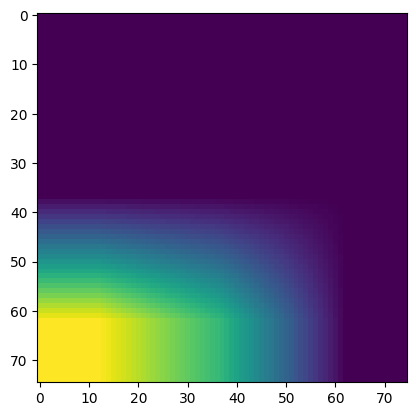

In [58]:
for i, (image, label, original) in enumerate(train_loader):
  pass
  if i == 10:
    break
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

model = uploaded_model
target_layers = [model.conv[-1]]
input_tensor = image
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

targets = [ClassifierOutputTarget(label[i])]

grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

grayscale_cam = grayscale_cam[0, :]
plt.imshow(grayscale_cam)
# plt.show()
# plt.imshow(image[0][0].permute(1,2,0))
# visualization = show_cam_on_image(image[0][0], grayscale_cam, use_rgb=False)